In [2]:
import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code')

from load import beas_sutlej_gauges, era5, data_dir
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import GPy
import scipy as sp
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
#from utils.metrics import msll
import xarray as xr

In [3]:
import emukit
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

In [4]:
# Load data
minyear = 2000
maxyear = 2000.2

In [5]:
all_station_dict = pd.read_csv( data_dir + 'bs_gauges/gauge_info.csv', index_col='station').T

In [6]:
station_list = list(all_station_dict)

In [7]:
hf_train_list = []
for station in station_list:
    station_ds = beas_sutlej_gauges.gauge_download(
        station, minyear=minyear, maxyear=maxyear)
    hf_train_list.append(station_ds.to_dataframe().dropna().reset_index())
hf_train_df = pd.concat(hf_train_list)

 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


In [48]:
# era5.collect_ERA5('indus', minyear=minyear, maxyear=maxyear)
era5_ds = era5.collect_ERA5('indus', minyear=minyear, maxyear=maxyear)
era5_df = era5_ds.to_dataframe()

lf_df = era5_df.dropna().reset_index()
lf_df1 = lf_df[lf_df['lat'] <= 33.5]
lf_df2 = lf_df1[lf_df1['lat'] >= 30.25]
lf_df3 = lf_df2[lf_df2['lon'] >= 75.75]
lf_train_df = lf_df3[lf_df3['lon'] <= 82.5]

indus
/Users/kenzatazi/Documents/CDT/Code/data/ERA5/combi_data_indus_02-2023.csv


In [49]:
# Import SRTM data
era5_ds = era5.collect_ERA5('beas_sutlej', minyear, maxyear)
srtm_ds = xr.open_dataset('/Users/kenzatazi/Documents/CDT/Code/data/Elevation/SRTM_data.nc')
srtm_ds = srtm_ds.rename({'nlat': 'lat', 'nlon': 'lon'})

indus
/Users/kenzatazi/Documents/CDT/Code/data/ERA5/combi_data_indus_02-2023.csv


In [10]:
rg_era5_ds = era5_ds.interp_like(srtm_ds, method='linear')
rg_srtm_ds = srtm_ds.interp_like(srtm_ds, method='linear')

In [11]:
hr_data_ds = xr.merge([rg_era5_ds.tp, srtm_ds.elevation])

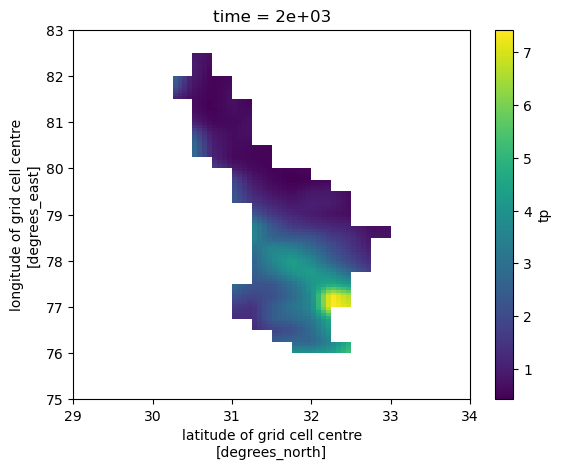

In [51]:
rg_era5_ds.tp.isel(time=0).plot()

In [13]:
era5_df.reset_index()

,time,lon,lat,z,d2m,anor,slor,tcwv,tp,N34
0,2000.041667,65.0,25.00,4.215096,285.566681,0.785410,0.000100,12.928228,0.117861,24.78
1,2000.041667,65.0,25.25,51.581131,283.052551,0.223698,0.007000,12.309038,0.115596,24.78
2,2000.041667,65.0,25.50,155.000854,278.240784,-1.402032,0.018066,11.435081,0.063464,24.78
3,2000.041667,65.0,25.75,288.421692,275.769379,-1.295923,0.012710,10.596571,0.104263,24.78
4,2000.041667,65.0,26.00,437.787903,273.535278,-1.218336,0.010194,9.701569,0.165459,24.78
...,...,...,...,...,...,...,...,...,...,...
9877,2000.125000,85.0,39.00,1102.141357,256.797333,-0.507543,0.000696,3.499695,0.000000,25.21
9878,2000.125000,85.0,39.25,1058.431763,257.187561,-0.813025,0.000502,3.638153,0.000000,25.21
9879,2000.125000,85.0,39.50,1020.813660,257.621460,-0.656672,0.000448,3.741169,0.002269,25.21
9880,2000.125000,85.0,39.75,994.391541,257.996796,-0.561046,0.000485,3.847504,0.002269,25.21


In [14]:
hr_data_ds.drop_vars(['longitude', 'latitude', 'tp'])

<xarray.Dataset>
Dimensions:    (time: 2, lon: 128, lat: 80)
Coordinates:
  * time       (time) float64 2e+03 2e+03
  * lon        (lon) float32 75.03 75.09 75.16 75.22 ... 82.78 82.84 82.91 82.97
  * lat        (lat) float32 29.03 29.09 29.16 29.22 ... 33.78 33.84 33.91 33.97
Data variables:
    elevation  (lat, lon) int16 ...

In [15]:
# Mask to beas and sutlej
mask_filepath = '/Users/kenzatazi/Documents/CDT/Code/data/Masks/Beas_Sutlej_highres_mask.nc'
mask = xr.open_dataset(mask_filepath)
mask_da = mask.Overlap
msk_hr_data_ds = srtm_ds.where(mask_da > 0, drop=True)

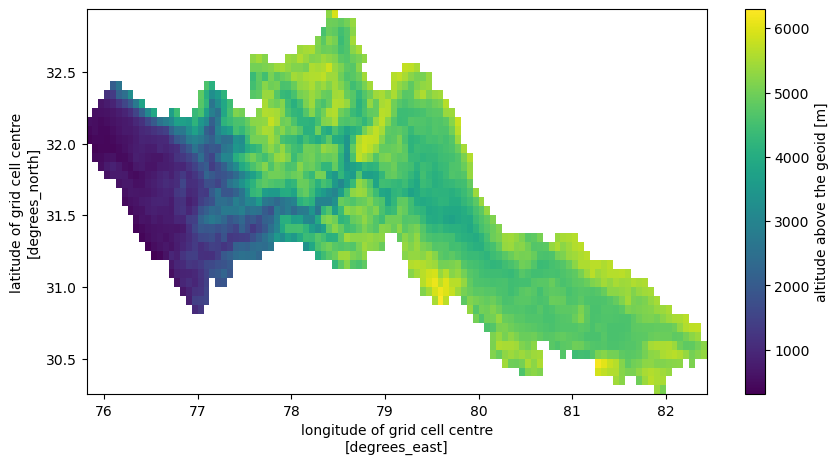

In [16]:
msk_hr_data_ds.elevation.plot(figsize=(10,5))

In [17]:
msk_hr_data_ds

<xarray.Dataset>
Dimensions:    (lat: 43, lon: 106)
Coordinates:
  * lat        (lat) float32 30.28 30.34 30.41 30.47 ... 32.72 32.78 32.84 32.91
  * lon        (lon) float32 75.84 75.91 75.97 76.03 ... 82.22 82.28 82.34 82.41
    latitude   (lat) float32 30.28 30.34 30.41 30.47 ... 32.72 32.78 32.84 32.91
    longitude  (lon) float32 75.84 75.91 75.97 76.03 ... 82.22 82.28 82.34 82.41
Data variables:
    elevation  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    slope      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    aspect     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/13)
    institution:                KNMI / TEMIS
    url:                        http://temis.nl/data/gmted2010/
    Title:                      GMTED2010 elevation data regridded at 0.062 d...
    resolution_degrees:         0.0625
    resolution_summing_factor:  15
    input_file:                 S5P_OPER_REF_DEM_15_00000000T000000_99999999T...
    ...                         ...
    input_note:                 see "Original_attributes" for a copy of the a...
    creation_date:              2019-10-15
    gmted2010_citation:         Danielson, J.J., and Gesch, D.B., 2011, Globa...
    gmted2010_citation_url:     http://pubs.usgs.gov/of/2011/1073/pdf/of2011-...
    gmted2010_viewer_url:       http://topotools.cr.usgs.gov/gmted_viewer/
    history:                    2016-01-11: Conversion from HDF-5 by Maarten ...

In [18]:
msk_hr_data_df = msk_hr_data_ds.to_dataframe().dropna().reset_index()

In [19]:
msk_hr_data_df['time'] = era5_df.reset_index()['time'][0]* np.ones(len(msk_hr_data_df))

In [20]:
msk_hr_data_df

,lat,lon,elevation,slope,aspect,latitude,longitude,time
0,30.28125,81.90625,5383.0,239.961060,38.613197,30.28125,81.90625,2000.041667
1,30.28125,81.96875,5071.0,322.726318,21.327494,30.28125,81.96875,2000.041667
2,30.34375,81.46875,5446.0,254.011627,70.120476,30.34375,81.46875,2000.041667
3,30.34375,81.53125,5237.0,185.285004,73.741341,30.34375,81.53125,2000.041667
4,30.34375,81.71875,4978.0,314.256500,311.839844,30.34375,81.71875,2000.041667
...,...,...,...,...,...,...,...,...
1784,32.84375,78.53125,4833.0,408.887238,15.043118,32.84375,78.53125,2000.041667
1785,32.84375,78.59375,5025.0,289.944244,312.833649,32.84375,78.59375,2000.041667
1786,32.84375,78.65625,5352.0,129.439423,273.100037,32.84375,78.65625,2000.041667
1787,32.90625,78.40625,5257.0,638.887573,299.052429,32.90625,78.40625,2000.041667


In [66]:
print(lin_mf_model)

In [65]:
print(gpy_lin_mf_model.multifidelity.rbf_1.lengthscale)

  index  |  gp.multifidelity.rbf_1.lengthscale  |  constraints  |  priors
  [0]    |                          0.92755030  |      +ve      |        
  [1]    |                          0.59960254  |      +ve      |        
  [2]    |                          0.03084279  |      +ve      |        
  [3]    |                          0.54435863  |      +ve      |        


In [64]:
gpy_lin_mf_model.multifidelity.rbf_1.lengthscale.constrain_bounded(0.10, 1)

AttributeError: 'Logistic' object has no attribute 'lower'

In [39]:
# Prepare data

# Transformations
lf_train_df['tp_tr'], lf_lambda = sp.stats.boxcox(
    lf_train_df['tp'].values + 0.01)
hf_train_df['tp_tr'] = sp.stats.boxcox(
    hf_train_df['tp'].values + 0.01, lmbda=lf_lambda)

# Splitting
x_train_lf = lf_train_df[['time', 'lat', 'lon', 'z']].values.reshape(-1, 4)
y_train_lf = lf_train_df['tp_tr'].values.reshape(-1, 1)
x_train_hf = hf_train_df[['time', 'lat', 'lon', 'z']].values.reshape(-1, 4)
y_train_hf = hf_train_df[['tp_tr']].values.reshape(-1, 1)
x_val = msk_hr_data_df[['time', 'lat', 'lon', 'elevation']].values.reshape(-1, 4)


# Scaling
scaler = StandardScaler().fit(x_train_hf)
x_train_hf1 = scaler.transform(x_train_hf)
x_train_lf1 = scaler.transform(x_train_lf)
x_val1 = scaler.transform(x_val)

# Input data
X_train, Y_train = convert_xy_lists_to_arrays([x_train_lf1[:], x_train_hf1[:]], [y_train_lf[:], y_train_hf[:]])

# Train and evaluate
kern1 = GPy.kern.RBF(input_dim=4, ARD=True)
kernels = [kern1, GPy.kern.RBF(input_dim=4, ARD=True)]
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2,)
gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)
gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0.1)
lin_mf_model = GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=5)
lin_mf_model.optimize()

 /var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_71606/3897818388.py:4: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Optimization restart 1/5, f = 363.9883091742993
Optimization restart 2/5, f = 365.93430695972086
Optimization restart 3/5, f = 363.988309648615
Optimization restart 4/5, f = 368.01354394608103
Optimization restart 5/5, f = 414.8265455691594


In [24]:
x_val = msk_hr_data_df[['time', 'lat', 'lon', 'elevation']].values.reshape(-1, 4)

In [25]:
x_val1 = scaler.transform(x_val)

In [40]:
# ALL
n = x_val.shape[0]
x_met = convert_x_list_to_array([x_val1, x_val1])
y_pred0, y_var0 = lin_mf_model.predict(x_met[n:])
y_pred_low0, y_var_low0 = lin_mf_model.predict(x_met[:n])

In [41]:
# ALL
y_pred = sp.special.inv_boxcox(y_pred0, lf_lambda).reshape(-1)
y_pred_low = sp.special.inv_boxcox(y_pred_low0, lf_lambda).reshape(-1)
msk_hr_data_df['pred'] = y_pred
msk_hr_data_df['pred_low'] = y_pred_low

<AxesSubplot: >

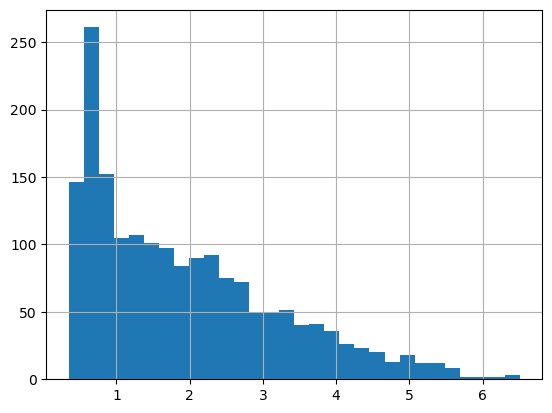

In [47]:
msk_hr_data_df['pred_low'].hist(bins=30)

<AxesSubplot: >

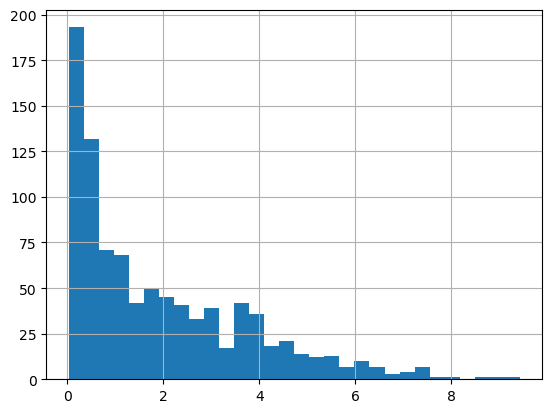

In [43]:
lf_train_df['tp'].hist(bins=30)

<AxesSubplot: xlabel='lon', ylabel='lat'>

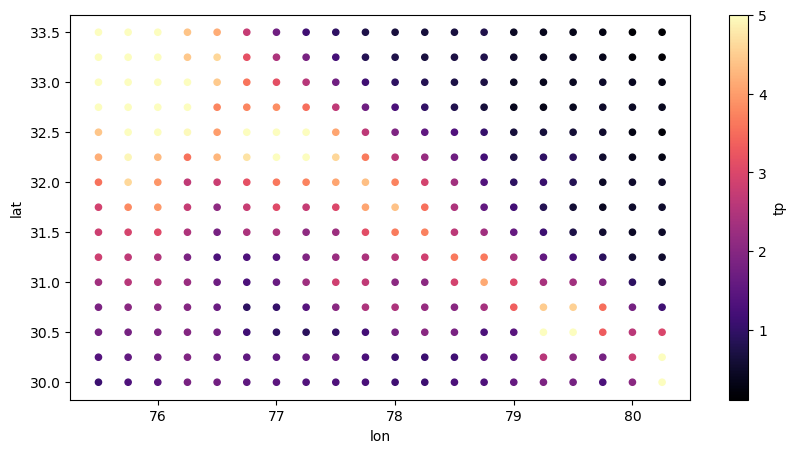

In [44]:
lf_train_df[:300].plot.scatter(x='lon', y='lat', c='tp',figsize=(10,5), cmap='magma', vmax=5)

<AxesSubplot: xlabel='lon', ylabel='lat'>

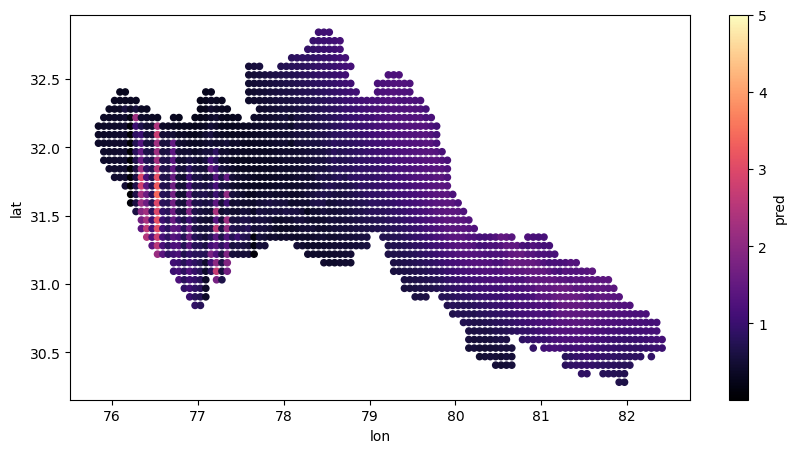

In [45]:
 msk_hr_data_df[:1785].plot.scatter(x='lon', y='lat', c='pred', vmax=5, figsize=(10,5), cmap='magma')

<AxesSubplot: xlabel='lon', ylabel='lat'>

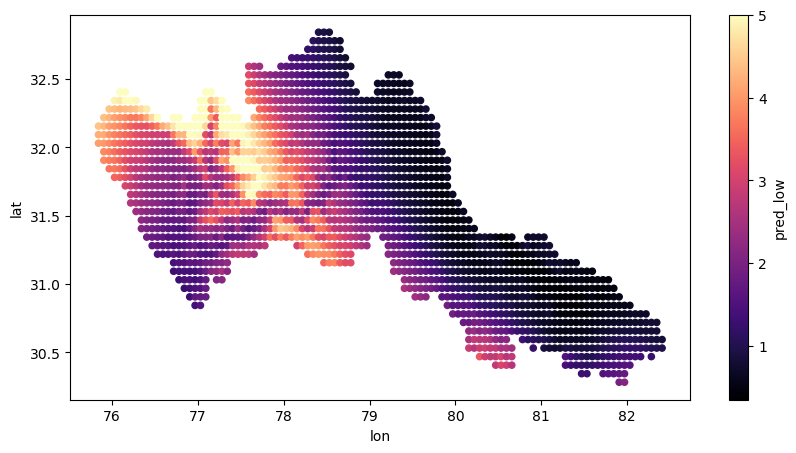

In [46]:
 msk_hr_data_df[:1785].plot.scatter(x='lon', y='lat', c='pred_low', vmax=5, figsize=(10,5), cmap='magma')